# Placa Estática 2D

> Notebook adaptado da resolução do exercício 17 em [Kollmannsberger 2ed](https://github.com/cmpmech/deep-learning-in-computational-mechanics/tree/main)  
**Notebook por:** Paulo de Souza Silva  
**Data:** Maio/Junho de 2025


**IGNORE ESTE CÓDIGO INICIAL**

* Se a figura da viga não aparecer, basta rodá-lo.

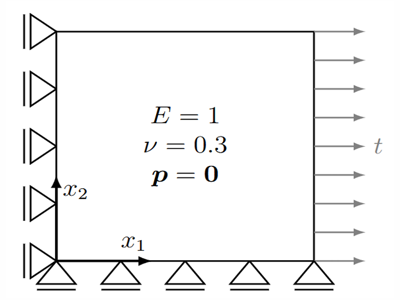

In [ ]:
import requests
from PIL import Image
from io import BytesIO

file_id = '1OzBxRbJeqIFQCTIMIJcG7fX7izi65ZX0'
url = f'https://drive.google.com/uc?export=view&id={file_id}'

response = requests.get(url)
img = Image.open(BytesIO(response.content))

new_size = (400, 300)  # (largura, altura) em pixels
img_resized = img.resize(new_size)

display(img_resized)

**bibliotecas importantes**

In [ ]:
import numpy as np
import torch
from torch.autograd import grad
import time
import matplotlib.pyplot as plt

## Definições Iniciais

**cálculo de gradientes com diferenciação automática**

In [ ]:
def getDerivative(y, x, n):
    if n == 0:
        return y
    else:
        dy_dx = grad(y, x, torch.ones(x.shape), create_graph=True, retain_graph=True)[0]
        return getDerivative(dy_dx, x, n - 1)

**rede neural**  
Aqui é utilizado um formato ainda mais geral do que no caso do problema unidimensional, mas segue a mesma lógica:

* Definir a função construtora `__init__`
* Gerar a construção automática da rede de acordo com a quantidade de camadas ocultas e número de neurônios
* A função de ativação **Tangente Hiperbólica** é definida como padrão
* Os demais comandos como `nn.Linear` e `nn.Sequential`foram explicados no outro notebook

In [ ]:
class NN(torch.nn.Module):
    def __init__(
        self,
        inputDimension,
        hiddenDimensions,
        outputDimension,
        activationFunction=torch.nn.Tanh(),
    ):
        super().__init__()

        modules = []
        modules.append(torch.nn.Linear(inputDimension, hiddenDimensions[0]))
        modules.append(activationFunction)
        for i in range(len(hiddenDimensions) - 1):
            modules.append(
                torch.nn.Linear(hiddenDimensions[i], hiddenDimensions[i + 1])
            )
            modules.append(activationFunction)
        modules.append(torch.nn.Linear(hiddenDimensions[-1], outputDimension))

        self.model = torch.nn.Sequential(*modules)

    def forward(self, x):
        u = self.model(x)
        return u

**Criação de um grid**

Como nosso problema é bidimensional, precisamos criar um grid de pontos, nas direções x e y.  
Assim é definida uma função **`getGrid`** que recebe as dimensões de cada lado do quadrado $(L_x, L_y)$ e número de pontos na direção x e y $(N_x, N_y)$

**Tome nota** `torch.cat((x.reshape(-1, 1), y.reshape(-1, 1)), 1)` concatena as matrizes x e y achatadas (flattened) em uma única matriz de tamanho $(N_x \times N_y, 2)$ onde cada linha é um par $(x_i, y_i)$



In [ ]:
def getGrid(Lx, Ly, Nx, Ny):
    x = torch.linspace(0, Lx, Nx)
    y = torch.linspace(0, Ly, Ny)
    x, y = torch.meshgrid(x, y, indexing="ij")
    x.requires_grad = True
    y.requires_grad = True
    input = torch.cat((x.reshape(-1, 1), y.reshape(-1, 1)), 1)
    return x, y, input

**condição de contorno de Dirichlet na forma forte**

Para forçar que não haja deslocamento nas direções $u_y(x,0)$ e $u_x(0,y)$ é possível adotar a estratégia de definir o contorno de maneira **FORTE**, isto é, impondo no deslocamento funções que dependendam das coordenadas.

In [ ]:
    # Dirichlet boundary conditions through strong enforcement
    strongEnforcementx = lambda u_x, x, y: x * u_x
    strongEnforcementy = lambda u_y, x, y: y * u_y

**Parametros Físicos**

Da Lei de Hooke em 2D, temos que a matriz de coeficientes materiais é expressa por:

$$C = \frac{E}{1-\nu^2} \begin{bmatrix}
1 & \nu & 0 \\
\nu & 1 & 0 \\
0 & 0 & 1 - \nu
\end{bmatrix}
$$


In [ ]:
# Dados do Problema
Lx = 1      # Comprimento em x
Ly = 1      # Comprimento em y
E = 1.0     # Modulo de Elasticidade
nu = 0.3    # Coeficiente de Poisson

C = torch.zeros((3, 3))
C[0, 0] = 1
C[0, 1] = nu
C[1, 0] = nu
C[1, 1] = 1
C[2, 2] = 1 - nu
C *= E / (1 - nu**2)


## Funções para criar a PINN

**calculo do deslocamento**
$$\hat{\boldsymbol{u}}=(\hat{u},\hat{v})^\intercal=F_{NN}(x)$$

os deslocamentos que queremos calcular são resultados da rede.

O método **`.unsqueeze(1)`** no PyTorch (ou em bibliotecas baseadas nele, como o SciANN) adiciona uma dimensão extra ao tensor na posição especificada (**no caso, 1,** que é a segunda dimensão).

Isso é útil para garantir que o tensor tenha a forma (shape) correta para operações subsequentes.

In [ ]:
def getDisplacements(model, input, strongEnforcementx, strongEnforcementy):
    u = model(input)
    ux = strongEnforcementx(u[:, 0], input[:, 0], input[:, 1]).unsqueeze(1)
    uy = strongEnforcementy(u[:, 1], input[:, 0], input[:, 1]).unsqueeze(1)
    u = torch.cat((ux, uy), 1)
    return u  # model(x)

**cálculo das deformações**

Da teoria da elasticidade linear, podemos calcular as deformações $\varepsilon_x, \varepsilon_y$ e $\varepsilon_{xy}$ seguindo o equacionamento a seguir

$$\boldsymbol{\varepsilon}=\begin{pmatrix}
\frac{\partial u}{\partial x}\\
\frac{\partial v}{\partial y}\\
\frac{1}{2}(\frac{\partial u}{\partial y} + \frac{\partial v}{\partial x})
\end{pmatrix}
$$

vamos definir uma função **`getStrains`** que deve receber: $u, x, y, N_x, N_y$ e retornar as três deformações

In [ ]:
def getStrains(u, x, y, Nx, Ny):
    strain = torch.zeros((3, Nx, Ny))
    strain[0] = getDerivative(u[:, 0].reshape(Nx, Ny), x, 1)
    strain[1] = getDerivative(u[:, 1].reshape(Nx, Ny), y, 1)
    strain[2] = 0.5 * (
        getDerivative(u[:, 0].reshape(Nx, Ny), y, 1)
        + getDerivative(u[:, 1].reshape(Nx, Ny), x, 1)
    )
    return strain

**calculo das funcões de perda**

**tensão** $$\boldsymbol{\sigma}=\boldsymbol{C}\boldsymbol{\varepsilon}$$

**residuo** $$\boldsymbol{r}=\nabla \cdot \boldsymbol{\sigma} + \boldsymbol{p}$$

como no caso $\boldsymbol{p} = 0$ a equação anterior pode ser expressa como:

$$\boldsymbol{r}= \begin{bmatrix}
\frac{\partial \sigma_{11}}{\partial x_1} + \frac{\partial \sigma_{12}}{\partial x_{2}} \\
\frac{\partial \sigma_{21}}{\partial x_1} + \frac{\partial \sigma_{22}}{\partial x_{2}}
\end{bmatrix}$$

**perda residual** $$\mathcal{L}_R = \frac{1}{N}\sum_i^N \sum_j^2 (\hat{\boldsymbol{r}}_j)^2$$

perda do contorno (necessária apenas para a condição de contorno de Neumann quando a forma forte é usada na condição de Dirichlet)

$$\mathcal{L}_B=\frac{1}{N_{11}}\sum_i^{N_{11}} (\hat{\sigma}_{11}-\tilde{\sigma}_{11})^2 + \frac{1}{N_{22}}\sum_i^{N_{22}} (\hat{\sigma}_{22}-\tilde{\sigma}_{22})^2 + \frac{1}{N_{12}}\sum_i^{N_{12}} (\hat{\sigma}_{12}-\tilde{\sigma}_{12})^2$$

Pelo cenário definido, tem-se:
$$
\begin{aligned}
\sigma_{22}(x_1,L) &= 0 \hspace{1cm} \sigma_{11}(L,x_2) = t \\
\sigma_{12}(x_1,0) &= 0 \hspace{1cm} \sigma_{12}(0,x_2) = 0 \hspace{1cm} \sigma_{12}(x_1,L) = 0 \hspace{1cm} \sigma_{12}(L,x_2) = 0   
\end{aligned}
$$


In [ ]:
def getLossTerms(x, y, u, Nx, Ny, C):
    strain = getStrains(u, x, y, Nx, Ny)         # Deformacao
    stress = torch.tensordot(C, strain, dims=1)  # Tensoes sig = C * eps

    # Derivadas das tensoes
    dsig11_dx = getDerivative(stress[0], x, 1)
    dsig12_dy = getDerivative(stress[2], y, 1)
    dsig21_dx = getDerivative(stress[2], x, 1)
    dsig22_dy = getDerivative(stress[1], y, 1)

    # equilibrio
    EDP_Loss = 0
    EDP_Loss += torch.sum((dsig11_dx + dsig12_dy) ** 2) / (Nx * Ny)
    EDP_Loss += torch.sum((dsig21_dx + dsig22_dy) ** 2) / (Nx * Ny)

    # inicializacao das condicoes de contorno
    BC_Loss = 0

    # Neumann boundary condition on right edge
    traction = 1

    ################ inhomogeneous Neumann boundary conditions #################
    # homogeneous Neumann boundary conditions still have to be enforced
    BC_Loss += torch.sum((stress[0][-1, :] - traction) ** 2) / Nx

    # tensao de normal na parte superior
    BC_Loss += (torch.sum((stress[1][:, -1] - 0) ** 2) / Nx)

    # tensao de cisalhamento na parte superior
    BC_Loss += (torch.sum((stress[2][:, -1] - 0) ** 2) / Nx)

    # tensao de cisalhamento na parte inferior
    BC_Loss += (torch.sum((stress[2][:, 0] - 0) ** 2) / Nx)

    # tensao de cisalhamento na lateral esquerda
    BC_Loss += (torch.sum((stress[2][0, :] - 0) ** 2) / Ny)

    # tensao de cisalhamento na lateral direita
    BC_Loss += (torch.sum((stress[2][-1, :] - 0) ** 2) / Ny)

    return EDP_Loss, BC_Loss

## Estrutura do Problema

**hiperparametros**

* Haverá 100 pontos de colocação (10 x 10)
* A rede terá **3 camadas escondidas** com **20 neurônios**
* A função de ativação será a **Tangente Hiperbólica (ou SiLU)**
* Será utilizado o **otimizador Adam**.
* Serão 501 épocas, com taxa de aprendizagem de 0.01

**Tome nota:** **`weightLrFactor`** Esse parâmetro controla um fator de multiplicação aplicado à taxa de aprendizado (learning rate) para os pesos da rede neural (não confundir com a taxa de aprendizado global).



In [ ]:
Nx = 10  # number of collocation points in x
Ny = 10  # number of collocation points in y
hiddenDimensions = [20, 20, 20]
activationFunction = torch.nn.SiLU()

epochs = 501  # number of epochs
lr = 1e-2  # learning rate
weightLrFactor = 1e1
selectOptimizer = "Adam"

**rede e otimizador**

In [ ]:
model = NN(2, hiddenDimensions, 2, activationFunction)
optimizer = torch.optim.Adam(model.parameters(), lr)

weights = torch.ones(2)
weights.requires_grad = True
optimizer.add_param_group({"params": weights})
optimizer.param_groups[-1]["lr"] = lr * weightLrFactor

**pontos do treinamento**

In [ ]:
x, y, input = getGrid(Lx, Ly, Nx, Ny)

## Treinamento

**funcao custo / perda total**

A função custo é a soma da loss da PDE e das BCs
$$C=\kappa_R\mathcal{L}_R + \kappa_B\mathcal{L}_B$$

In [ ]:
##################################################
# Inicializacoes
EDP_LossHistory = np.zeros(epochs)  # historico da edp
BC_LossHistory = np.zeros(epochs)   # historico das BCs
costHistory = np.zeros(epochs)      # historico do custo
start = time.perf_counter()         # contador de tempo
start0 = start                      # tempo inicial
#################################################
# Inicio da otimizacao
for epoch in range(epochs):
    optimizer.zero_grad()   #zerando os gradientes
    uPred = getDisplacements(model, input, strongEnforcementx, strongEnforcementy) #gerando o deslocamento via rede
    lossTerms = getLossTerms(x, y, uPred, Nx, Ny, C)  # gerando as funcoes de perda da EDP e das BCs
    cost = weights[0] * lossTerms[0] + weights[1] * lossTerms[1]  # funcao custo
    cost.backward()               # aplicacao do backpropagation da funcao custo
    weights.grad *= -1            # inversao de sinais dos gradientes
    optimizer.step()              # passo da otimizacao

    # Historico das funçoes de perda e custo
    EDP_LossHistory[epoch] = lossTerms[0].detach()
    BC_LossHistory[epoch] = lossTerms[1].detach()
    costHistory[epoch] = lossTerms[0].detach() + lossTerms[1].detach()

    # Print formatado dos resultados
    if epoch % 50 == 0:
        elapsedTime = (time.perf_counter() - start) / 50
        string = "Epoch: {}/{}\t\tDE cost = {:.2e}\t\tBC cost = {:.2e}\t\tTotal cost = {:.2e}\t\tElapsed time = {:2f}"
        print(
            string.format(
                epoch,
                epochs,
                EDP_LossHistory[epoch],
                BC_LossHistory[epoch],
                costHistory[epoch],
                elapsedTime,
            )
        )
        start = time.perf_counter()
elapsedTime = time.perf_counter() - start0
string = "Total elapsed time: {:2f}\nAverage elapsed time per epoch: {:2f}"
print(string.format(elapsedTime, elapsedTime / epochs))

Epoch: 0/501		DE cost = 9.53e-04		BC cost = 8.13e-01		Total cost = 8.14e-01		Elapsed time = 0.001286
Epoch: 50/501		DE cost = 2.69e-05		BC cost = 5.14e-05		Total cost = 7.83e-05		Elapsed time = 0.054951
Epoch: 100/501		DE cost = 3.00e-06		BC cost = 1.03e-06		Total cost = 4.03e-06		Elapsed time = 0.042769
Epoch: 150/501		DE cost = 1.77e-06		BC cost = 4.11e-07		Total cost = 2.18e-06		Elapsed time = 0.042659
Epoch: 200/501		DE cost = 1.51e-06		BC cost = 3.51e-07		Total cost = 1.87e-06		Elapsed time = 0.043300
Epoch: 250/501		DE cost = 1.32e-06		BC cost = 3.07e-07		Total cost = 1.63e-06		Elapsed time = 0.042717
Epoch: 300/501		DE cost = 1.15e-06		BC cost = 2.75e-07		Total cost = 1.43e-06		Elapsed time = 0.057050
Epoch: 350/501		DE cost = 9.99e-07		BC cost = 2.53e-07		Total cost = 1.25e-06		Elapsed time = 0.045472
Epoch: 400/501		DE cost = 8.66e-07		BC cost = 2.38e-07		Total cost = 1.10e-06		Elapsed time = 0.042552
Epoch: 450/501		DE cost = 7.52e-07		BC cost = 2.27e-07		Total cost = 9.79e-0

## Pos-processamento

**predicao dos deslocamentos**

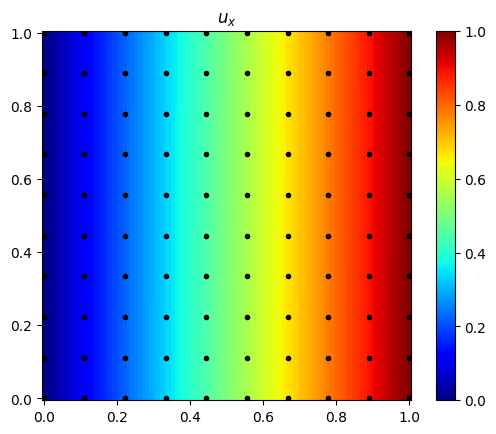

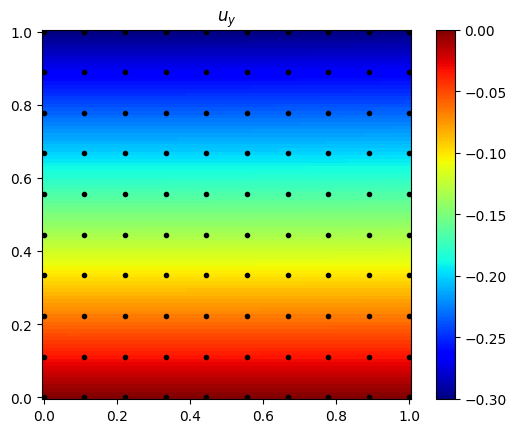

In [ ]:
Nx_ = 100
Ny_ = 100
x_, y_, input_ = getGrid(Lx, Ly, Nx_, Ny_)
upred = getDisplacements(model, input_, strongEnforcementx, strongEnforcementy)
strain = getStrains(upred, x_, y_, Nx_, Ny_)

#### Ajustando as dimensoes
xx = x_.detach()
yy = y_.detach()
u_x = upred[:, 0].reshape(Nx_, Ny_).detach()
u_y = upred[:, 1].reshape(Nx_, Ny_).detach()

##############################################
##           Fazendo os graficos            ##
##############################################
##      DESLOCAMENTO NA DIRECAO DE X        ##
fig, ax = plt.subplots()
cp = ax.pcolormesh(xx, yy, u_x, cmap=plt.cm.jet, shading='auto')
fig.colorbar(cp)
ax.plot(x.detach(), y.detach(), "k.")
plt.gca().set_aspect("equal", adjustable="box")
ax.set_title("$u_x$")
plt.show()

##############################################
##      DESLOCAMENTO NA DIRECAO DE Y        ##
fig, ax = plt.subplots()
cp = ax.pcolormesh(xx, yy, u_y, cmap=plt.cm.jet, shading='auto')
fig.colorbar(cp)
ax.plot(x.detach(), y.detach(), "k.")
plt.gca().set_aspect("equal", adjustable="box")
ax.set_title("$u_y$")
plt.show()

**histórico de treinamento**

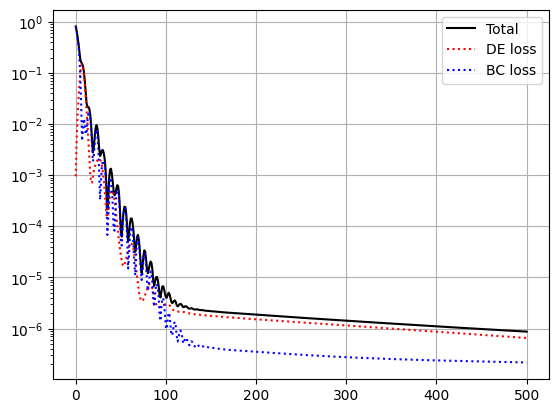

In [ ]:
fig, ax = plt.subplots()
ax.plot(costHistory, "k", label="Total")
ax.plot(EDP_LossHistory, "r:", label="DE loss")
ax.plot(BC_LossHistory, "b:", label="BC loss")
ax.set_yscale("log")
ax.grid()
ax.legend()
plt.show()